In [2]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy

import sys
sys.path.append('../')  

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec, waverec
from scipy import signal
from statsmodels.robust import mad

# Internal Imports
from wsae_lstm.utils import dictmap_load,pickle_load,pickle_save,dictmap_datetime

In [3]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
dict_dataframes_index.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [4]:
type(dict_dataframes_index['djia index data'])

dict

In [5]:
len(dict_dataframes_index['djia index data'])

24

In [14]:
for item in dict_dataframes_index['djia index data']:
    print("TRAIN:",dict_dataframes_index['nifty 50 index data'][item][1].index[0])
    #print("VAL:",dict_dataframes_index['nifty 50 index data'][item][2].index[0])
    #print("TEST:",dict_dataframes_index['nifty 50 index data'][item][3].index[0])

TRAIN: 2008-07-01 00:00:00
TRAIN: 2008-10-01 00:00:00
TRAIN: 2009-01-01 00:00:00
TRAIN: 2009-04-01 00:00:00
TRAIN: 2009-07-01 00:00:00
TRAIN: 2009-10-01 00:00:00
TRAIN: 2010-01-04 00:00:00
TRAIN: 2010-04-01 00:00:00
TRAIN: 2010-07-01 00:00:00
TRAIN: 2010-10-01 00:00:00
TRAIN: 2011-01-03 00:00:00
TRAIN: 2011-04-01 00:00:00
TRAIN: 2011-07-01 00:00:00
TRAIN: 2011-10-03 00:00:00
TRAIN: 2012-01-02 00:00:00
TRAIN: 2012-04-02 00:00:00
TRAIN: 2012-07-02 00:00:00
TRAIN: 2012-10-01 00:00:00
TRAIN: 2013-01-01 00:00:00
TRAIN: 2013-04-01 00:00:00
TRAIN: 2013-07-01 00:00:00
TRAIN: 2013-10-01 00:00:00
TRAIN: 2014-01-01 00:00:00
TRAIN: 2014-04-01 00:00:00


In [15]:
for item in dict_dataframes_index['djia index data']:
    #print("TRAIN:",dict_dataframes_index['nifty 50 index data'][item][1].index[0])
    print("VAL:",dict_dataframes_index['djia index data'][item][2].index[0])
    #print("TEST:",dict_dataframes_index['nifty 50 index data'][item][3].index[0])

VAL: 2010-07-01 00:00:00
VAL: 2010-10-01 00:00:00
VAL: 2011-01-03 00:00:00
VAL: 2011-04-01 00:00:00
VAL: 2011-07-01 00:00:00
VAL: 2011-10-03 00:00:00
VAL: 2012-01-04 00:00:00
VAL: 2012-04-02 00:00:00
VAL: 2012-07-02 00:00:00
VAL: 2012-10-01 00:00:00
VAL: 2013-01-03 00:00:00
VAL: 2013-04-01 00:00:00
VAL: 2013-07-01 00:00:00
VAL: 2013-10-03 00:00:00
VAL: 2014-01-02 00:00:00
VAL: 2014-04-02 00:00:00
VAL: 2014-07-02 00:00:00
VAL: 2014-10-01 00:00:00
VAL: 2015-01-01 00:00:00
VAL: 2015-04-01 00:00:00
VAL: 2015-07-01 00:00:00
VAL: 2015-10-01 00:00:00
VAL: 2016-01-01 00:00:00
VAL: 2016-04-01 00:00:00


In [16]:
for item in dict_dataframes_index['djia index data']:
    #print("TRAIN:",dict_dataframes_index['nifty 50 index data'][item][1].index[0])
    #print("VAL:",dict_dataframes_index['nifty 50 index data'][item][2].index[0])
    print("TEST:",dict_dataframes_index['djia index data'][item][3].index[0])

TEST: 2010-10-01 00:00:00
TEST: 2011-01-03 00:00:00
TEST: 2011-04-01 00:00:00
TEST: 2011-07-01 00:00:00
TEST: 2011-10-03 00:00:00
TEST: 2012-01-02 00:00:00
TEST: 2012-04-04 00:00:00
TEST: 2012-07-02 00:00:00
TEST: 2012-10-01 00:00:00
TEST: 2013-01-01 00:00:00
TEST: 2013-04-03 00:00:00
TEST: 2013-07-01 00:00:00
TEST: 2013-10-01 00:00:00
TEST: 2014-01-03 00:00:00
TEST: 2014-04-02 00:00:00
TEST: 2014-07-02 00:00:00
TEST: 2014-10-07 00:00:00
TEST: 2015-01-01 00:00:00
TEST: 2015-04-01 00:00:00
TEST: 2015-07-01 00:00:00
TEST: 2015-10-01 00:00:00
TEST: 2016-01-01 00:00:00
TEST: 2016-04-01 00:00:00
TEST: 2016-07-01 00:00:00


In [17]:
def denoise_periods(dict_dataframes):
    
    ddi_scaled = dict()
    ddi_denoised= dict() 
    for key, index_name in enumerate(dict_dataframes):
        ddi_denoised[index_name] = copy.deepcopy(dict_dataframes[index_name])
        ddi_scaled[index_name] = copy.deepcopy(dict_dataframes[index_name])
    for key, index_name in enumerate(ddi_denoised): 
        scaler = preprocessing.RobustScaler()

        for index,value in enumerate(ddi_denoised[index_name]):
            
            X_train = ddi_denoised[index_name][value][1]
            X_train_scaled = scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled,columns=list(X_train.columns))
            
            X_val = ddi_denoised[index_name][value][2]
            X_val_scaled = scaler.transform(X_val)
            X_val_scaled = pd.DataFrame(X_val_scaled,columns=list(X_val.columns))
            
            X_test = ddi_denoised[index_name][value][3]
            X_test_scaled = scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled,columns=list(X_test.columns))
            
            ddi_scaled[index_name][value][1] = X_train_scaled
            ddi_scaled[index_name][value][2] = X_val_scaled
            ddi_scaled[index_name][value][3] = X_test_scaled
            
            ddi_denoised[index_name][value][1] = waveletSmooth(X_train_scaled)
            ddi_denoised[index_name][value][2] = waveletSmooth(X_val_scaled)
            ddi_denoised[index_name][value][3] = waveletSmooth(X_test_scaled)
            
    return ddi_scaled,ddi_denoised

ddi_scaled,ddi_denoised = denoise_periods(dict_dataframes_index)

NameError: name 'preprocessing' is not defined

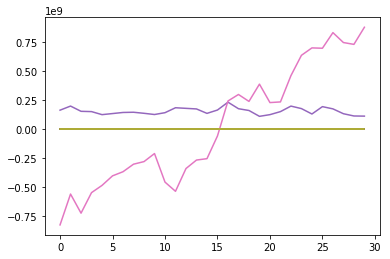

In [12]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1].values[:30]);

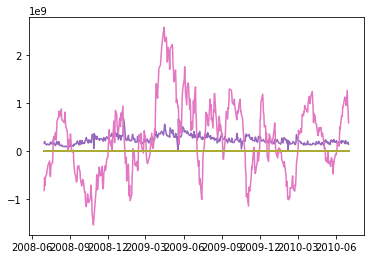

In [17]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1]);

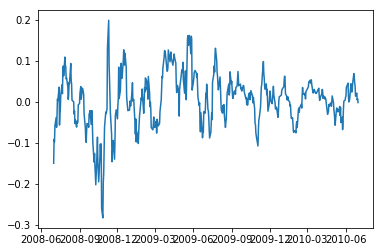

In [27]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1][['smi']])

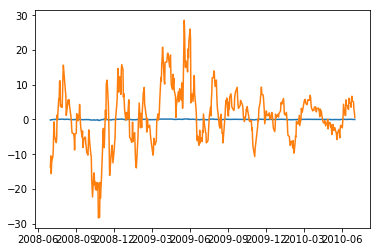

In [28]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1][['smi','roc']])

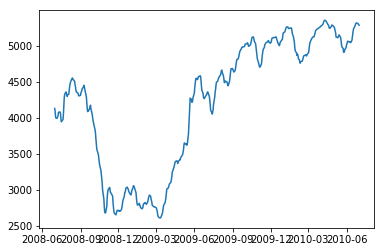

In [30]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1][['ma5']])

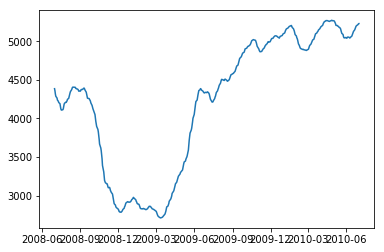

In [31]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1][['ema20']])

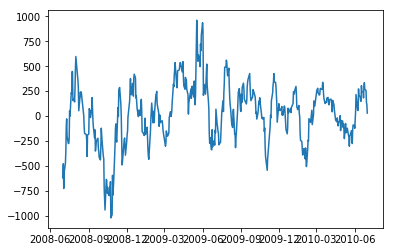

In [32]:
plt.plot(dict_dataframes_index['nifty 50 index data'][1][1][['mtm12']])

In [11]:
dict_dataframes_index['nifty 50 index data'][1][1][:10]

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2008-07-01,4039.75,4075.40,3878.20,3896.75,164469220,-201.56,-180.03,197.20,4409.04,4385.058946,4128.49,4253.415,-369.65,-620.35,-13.733369,-0.149627,-828023961.0,72.34,8.706
2008-07-02,3895.30,4107.15,3848.25,4093.35,199920144,-199.63,-131.91,258.90,4384.43,4357.277142,4096.63,4204.510,-97.75,-479.15,-10.478950,-0.091225,-561033032.0,71.99,7.730
2008-07-03,4094.60,4097.35,3874.85,3925.75,154573765,-209.21,-129.55,222.50,4346.87,4316.179319,4018.61,4146.660,-326.90,-727.25,-15.629701,-0.097020,-726253640.3,72.73,6.400
2008-07-04,3926.65,4033.50,3896.40,4016.00,152045352,-207.14,-111.08,137.10,4316.28,4287.590812,3994.48,4113.505,-299.85,-566.40,-12.360335,-0.058691,-548766472.1,72.71,6.210
2008-07-07,4002.00,4114.50,4002.00,4030.00,125737237,-202.03,-80.86,112.50,4292.73,4263.058354,3992.37,4089.865,-106.65,-474.25,-10.528945,-0.038439,-486195115.1,72.71,9.000
2008-07-08,4028.70,4028.70,3896.05,3988.55,135090953,-199.04,-95.40,133.95,4269.67,4236.914701,4010.73,4069.610,-52.00,-359.00,-8.257524,-0.062102,-403676976.1,72.96,9.030
2008-07-09,3990.90,4169.40,3990.90,4157.10,144597409,-180.98,-47.72,180.85,4251.34,4229.313301,4023.48,4060.055,260.35,-109.30,-2.561879,-0.036783,-367957785.4,72.59,9.070
2008-07-10,4155.65,4187.95,4110.40,4162.20,146458190,-164.36,-28.16,77.55,4232.49,4222.921558,4070.77,4044.690,68.85,-28.90,-0.689556,0.006139,-302822117.5,72.49,9.050
2008-07-11,4166.00,4215.50,4014.45,4049.00,137337875,-158.50,-44.54,201.05,4209.08,4206.357600,4077.37,4035.925,123.25,-203.65,-4.788779,0.002087,-280377888.0,71.91,9.060
